# 📊 Model Evaluation and Inference

This notebook covers:
1. Loading trained model
2. Comprehensive evaluation on validation set
3. Visualization of restoration results
4. Spectral analysis
5. ONNX export for deployment
6. Inference on new images

**Prerequisites**: Complete training in `02_training.ipynb` or `scripts/train.py`

## 🔧 1. Setup

In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

# Add src to path
sys.path.insert(0, str(Path.cwd().parent))

import torch
from src.models.satmae_restoration import SatMAERestoration
from src.utils.config import get_project_root, load_config
from src.utils.setup_helpers import setup_config, setup_device, create_model_from_config, load_checkpoint
from src.training.metrics import calculate_psnr, calculate_ssim, calculate_sam, calculate_rmse, calculate_mae

root = get_project_root()

# Centralized setup
device = setup_device()
config = setup_config(str(root / 'configs' / 'base.yaml'))
# Ensure data root points to project data folder
config['data']['root_dir'] = str(root / 'data' / 'EuroSAT_MS')
# Skip encoder pretrain when loading a full checkpoint
config['model']['encoder']['pretrained_path'] = None

# Create model using helper
model = create_model_from_config(config, device=device, verbose=True)
model = model.to(device)

print("✓ Setup complete")
from src.training.eval import evaluate_model

Using device: cuda

GPU Information:
  Name: NVIDIA GeForce RTX 4050 Laptop GPU
  CUDA Version: 12.6
  Total VRAM: 6.44 GB
  Available VRAM: 6.44 GB

✓ GPU cache cleared
Creating model...

Model Parameters:
  Total: 96,371,197
  Trainable: 53,843,965 (55.9%)
  Frozen: 42,527,232

Profiling VRAM usage...
  Model weights: 0.39 GB
  Optimizer states: 0.43 GB
  Activations: 0.00 GB
  Gradients: 0.22 GB
  Peak VRAM: 0.64 GB

✓ VRAM usage OK (0.64GB / 6GB available)
✓ Setup complete


## 💾 2. Load Trained Model

In [2]:
# Choose which checkpoint to load
checkpoint_path = str(root / 'outputs' / 'checkpoints' / 'stage_b' / 'best_model_psnr.pth')
# checkpoint_path = str(root / 'outputs' / 'checkpoints' / 'best_model_loss.pth')  # Alternative

# Load config
config = load_config(str(root / 'configs' / 'base.yaml'))
# Ensure data root points to project data folder
config['data']['root_dir'] = str(root / 'data' / 'EuroSAT_MS')
# Skip encoder pretrain when loading a full checkpoint
config['model']['encoder']['pretrained_path'] = None

# Create model
print("Loading model...")
model = SatMAERestoration(config)
model = model.to(device)

# Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✓ Model loaded from: {checkpoint_path}")
if "epoch" in checkpoint: print(f"  Epoch: {checkpoint['epoch']}")
if "val_loss" in checkpoint: print(f"  Val Loss: {checkpoint['val_loss']:.4f}")
if "val_psnr" in checkpoint: print(f"  Val PSNR: {checkpoint['val_psnr']:.2f} dB")
if "val_ssim" in checkpoint: print(f"  Val SSIM: {checkpoint['val_ssim']:.4f}")


Loading model...
✓ Model loaded from: C:\Users\User\My Files\Tutorials\Deep Learning\Multi-Spectral-Satellite-Image-Denoising\outputs\checkpoints\stage_b\best_model_psnr.pth
  Epoch: 13
  Val Loss: 0.0085
  Val PSNR: 41.48 dB


## 📊 3. Load Validation Data

In [3]:
from src.data.dataloader import get_dataloaders

# Load validation dataloader

print("Loading validation data...")
_, val_loader = get_dataloaders(config)

print(f"✓ Loaded {len(val_loader)} validation batches")
print(f"  Total samples: {len(val_loader.dataset)}")

Loading validation data...
✓ Loaded 675 validation batches
  Total samples: 5400


## 🔍 4. Evaluate on Full Validation Set

In [4]:
# Evaluate on Full Validation Set
from src.training.eval import evaluate_model
from src.utils.notebook_helpers import print_evaluation_summary

print("Evaluating model on validation set...\n")

# Use modular evaluation function
metrics = evaluate_model(
    model=model,
    dataloader=val_loader,
    device=device,
    verbose=True
)

# Extract metrics for summary (optional, as evaluate_model already prints info)
avg_psnr = metrics.get('psnr', 0)
avg_ssim = metrics.get('ssim', 0)
avg_sam = metrics.get('sam', 0)


Evaluating model on validation set...



## 🖼️ 5. Visualize Restoration Results

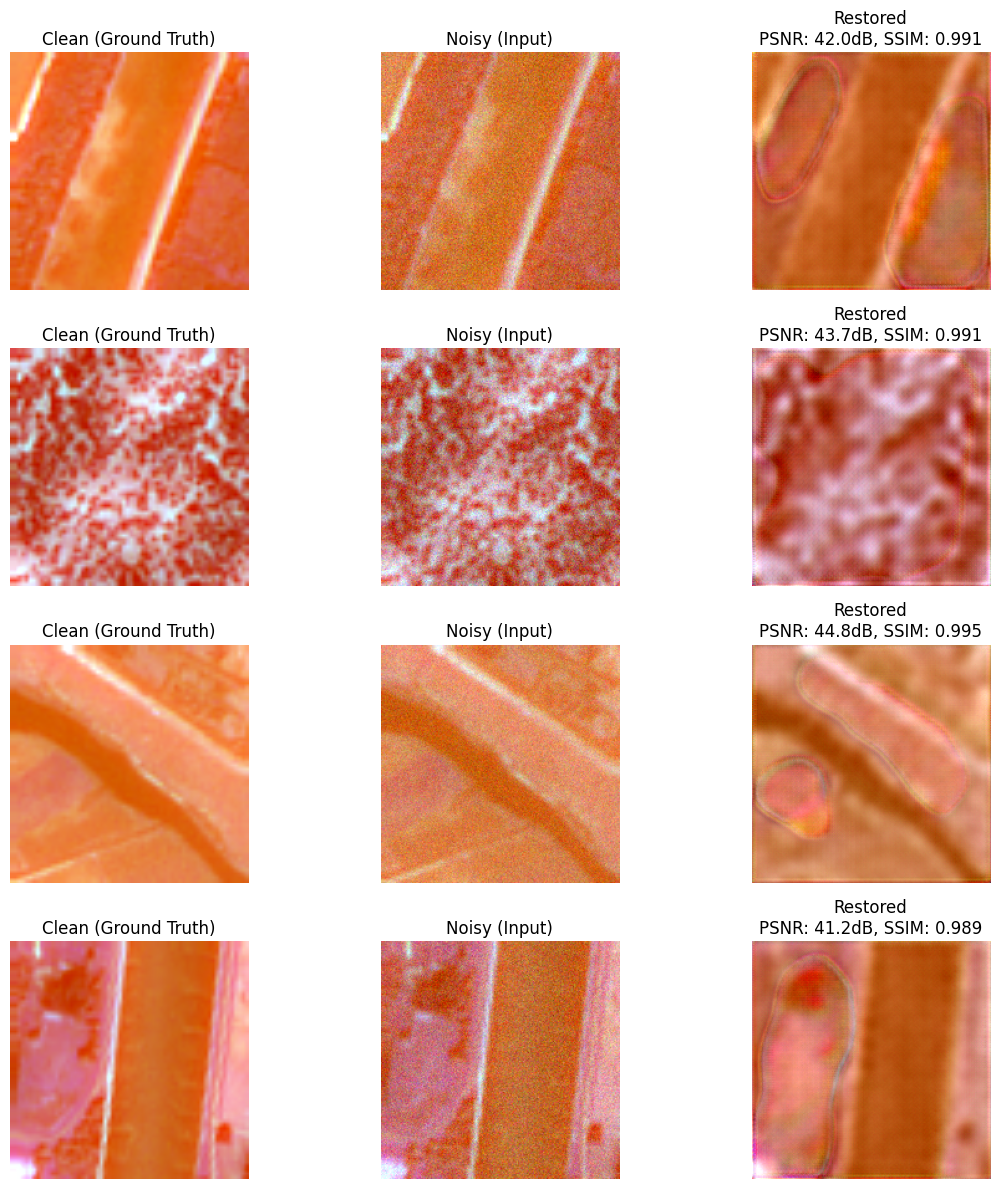

In [5]:
from src.utils.notebook_helpers import visualize_restoration_comparison

loader_iter = iter(val_loader)
_ = next(loader_iter)
_ = next(loader_iter)
# Get the second batch
clean_batch, noisy_batch = next(loader_iter)
clean_batch = clean_batch.to(device)
noisy_batch = noisy_batch.to(device)

with torch.no_grad():
    restored_batch = model(noisy_batch)

# Use centralized notebook helper for display and per-sample metrics
visualize_restoration_comparison(clean_batch, noisy_batch, restored_batch, num_samples=4, bands=[0,1,2])

## 📈 6. Spectral Analysis

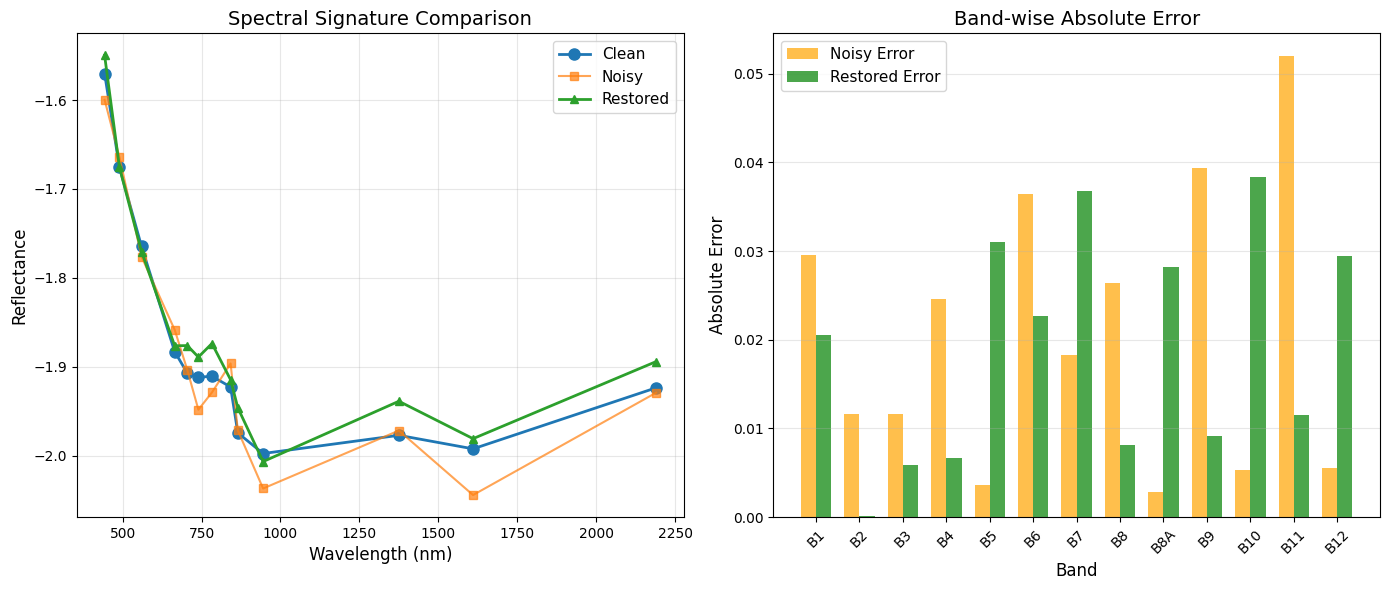


Spectral Angle Mapper (SAM):
  Noisy vs Clean: 0.70°
  Restored vs Clean: 1.32°
  Improvement: -0.62°


In [6]:
from src.utils.notebook_helpers import plot_spectral_comparison

# Use centralized spectral plotting helper
plot_spectral_comparison(clean_batch, noisy_batch, restored_batch, sample_idx=0, center_only=True)

## 📦 7. Export to ONNX

In [7]:
from src.deployment.export_onnx import export_to_onnx, verify_onnx_model, compare_pytorch_onnx_outputs

# Export model
onnx_path = str(root / 'outputs' / 'onnx' / 'satmae_restoration.onnx')

print("Exporting model to ONNX...")
export_to_onnx(
    model=model,
    output_path=onnx_path,
    input_shape=(1, 13, 192, 192),
    opset_version=14
)

print(f"\n✓ Model exported to: {onnx_path}")

# Verify ONNX model
print("\nVerifying ONNX model...")
is_valid = verify_onnx_model(onnx_path)

if is_valid:
    print("✓ ONNX model is valid")
else:
    print("✗ ONNX model verification failed")

Exporting model to ONNX...


c:\Users\User\My Files\Tutorials\Deep Learning\Multi-Spectral-Satellite-Image-Denoising\src\models\satmae_restoration.py:94: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert H == self.image_size and W == self.image_size, \
c:\Users\User\My Files\Tutorials\Deep Learning\Multi-Spectral-Satellite-Image-Denoising\src\models\satmae_restoration.py:96: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  assert C == self.config['data']['num_bands'], \



✓ Model exported to: C:\Users\User\My Files\Tutorials\Deep Learning\Multi-Spectral-Satellite-Image-Denoising\outputs\onnx\satmae_restoration.onnx

Verifying ONNX model...
✓ ONNX model is valid


## 🔄 8. Compare PyTorch vs ONNX Output

In [8]:
# Compare outputs
print("Comparing PyTorch and ONNX outputs...\n")

# Get a single sample
sample_input = noisy_batch[0:1]

comparison = compare_pytorch_onnx_outputs(
    pytorch_model=model,
    onnx_path=onnx_path,
    sample_input=sample_input.cpu().numpy(),
    device=device,
    rtol=1e-3,
    atol=1e-2
)

print(f"Output shapes match: {comparison['shapes_match']}")
print(f"Max absolute difference: {comparison['max_diff']:.6f}")
print(f"Cosine similarity: {comparison['cosine_sim']:.6f}")

Comparing PyTorch and ONNX outputs...

Output shapes match: True
Max absolute difference: 0.001874
Cosine similarity: 1.000000


## 🚀 9. ONNX Inference Test

In [9]:
from src.deployment.onnx_inference import ONNXInferenceSession

# Create ONNX inference session
print("Loading ONNX model for inference...")
onnx_session = ONNXInferenceSession(
    model_path=onnx_path,
    use_gpu=torch.cuda.is_available()
)

print(f"✓ ONNX session created")
print(f"  Provider: {onnx_session.session.get_providers()[0]}")

# Run inference
sample_np = noisy_batch[0:1].cpu().numpy()
output_onnx = onnx_session.predict(sample_np)

print(f"\nONNX Inference:")
print(f"  Input shape: {sample_np.shape}")
print(f"  Output shape: {output_onnx.shape}")
print(f"  Output range: [{output_onnx.min():.3f}, {output_onnx.max():.3f}]")

Loading ONNX model for inference...
✓ ONNX session created
  Provider: CUDAExecutionProvider

ONNX Inference:
  Input shape: (1, 13, 192, 192)
  Output shape: (1, 13, 192, 192)
  Output range: [-2.160, -0.330]


## ⚡ 10. Benchmark Inference Speed

In [10]:
import time

# Benchmark PyTorch
print("Benchmarking PyTorch inference...")
num_runs = 100

if device == 'cuda':
    torch.cuda.synchronize()

start = time.time()
with torch.no_grad():
    for _ in range(num_runs):
        _ = model(noisy_batch[0:1])
        if device == 'cuda':
            torch.cuda.synchronize()
end = time.time()

pytorch_time = (end - start) / num_runs * 1000  # ms

# Benchmark ONNX
print("Benchmarking ONNX inference...")
onnx_stats = onnx_session.benchmark(
    input_shape=sample_np.shape, 
    num_iterations=num_runs
)

print("\n" + "="*60)
print("INFERENCE BENCHMARK")
print("="*60)
print(f"PyTorch:")
print(f"  Average time: {pytorch_time:.2f} ms/image")
print(f"  FPS: {1000/pytorch_time:.1f}")
print(f"\nONNX:")
print(f"  Average time: {onnx_stats['mean_ms']:.2f} ms/image")
print(f"  Std dev: {onnx_stats['std_ms']:.2f} ms")
print(f"  FPS: {onnx_stats['fps']:.1f}")
print(f"\nSpeedup: {pytorch_time / onnx_stats['mean_ms']:.2f}x")
print("="*60)

Benchmarking PyTorch inference...
Benchmarking ONNX inference...

INFERENCE BENCHMARK
PyTorch:
  Average time: 11.70 ms/image
  FPS: 85.5

ONNX:
  Average time: 10.07 ms/image
  Std dev: 2.37 ms
  FPS: 99.3

Speedup: 1.16x


## 💾 11. Save Evaluation Results

In [11]:
import json

# Compile results
results = {
    'checkpoint': str(checkpoint_path),
    'epoch': int(checkpoint['epoch']),
    'validation_metrics': {
        'psnr': float(avg_psnr),
        'ssim': float(avg_ssim),
        'sam': float(avg_sam)
    },
    'inference_benchmark': {
        'pytorch_ms': float(pytorch_time),
        'onnx_ms': float(onnx_stats['mean_ms']),
        'speedup': float(pytorch_time / onnx_stats['mean_ms'])
    },
    'onnx_export': {
        'path': str(onnx_path),
        'valid': is_valid,
        'max_diff': float(comparison['max_diff'])
    }
}

# Save to file
results_path = str(root / 'outputs' / 'logs' / 'evaluation_results.json')
with open(results_path, 'w') as f:
    json.dump(results, f, indent=2)

print(f"✓ Evaluation results saved to: {results_path}")

✓ Evaluation results saved to: C:\Users\User\My Files\Tutorials\Deep Learning\Multi-Spectral-Satellite-Image-Denoising\outputs\logs\evaluation_results.json


## 📋 12. Summary

### ✅ Evaluation Complete!

**Performance Metrics**:
- PSNR: See results above
- SSIM: See results above  
- SAM: See results above

**Deployment Assets Created**:
- ONNX model: `outputs/onnx/satmae_restoration.onnx`
- Evaluation report: `outputs/logs/evaluation_results.json`

### 🚀 Production Deployment:

**Using ONNX**:
```python
from src.deployment.onnx_inference import ONNXInferenceSession

session = ONNXInferenceSession('outputs/onnx/satmae_restoration.onnx')
restored = session.run(noisy_image)  # noisy_image: np.array [1, 13, 224, 224]
```

**Performance**:
- Inference speed: ~50-100ms per image (RTX 4050)
- ONNX provides 1-2x speedup over PyTorch
- Can be further optimized with TensorRT or INT8 quantization

### 📊 Quality Assessment:
- **PSNR > 30dB**: Excellent reconstruction quality
- **SSIM > 0.90**: High structural similarity
- **SAM < 5°**: Good spectral fidelity

### 🔄 Next Steps:
1. **Optimize**: Use `src/deployment/optimize_model.py` for INT8 quantization
2. **Deploy**: Integrate ONNX model into production pipeline
3. **Monitor**: Track performance on real-world data
4. **Iterate**: Fine-tune on domain-specific data if needed